In [2]:
import os
import warnings
import pandas as pd
import networkx as nx
import matplotlib as mpl
from empiricaldist import Cdf
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from bokeh.plotting import figure
import matplotlib.colors as mcolors
from utils import decorate, savefig
from bokeh.transform import linear_cmap
from bokeh.plotting import from_networkx
from bokeh.io import output_notebook, show, save
from networkx.drawing.nx_agraph import graphviz_layout
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8,Inferno
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, ColorBar, LabelSet, LogColorMapper

# Delhi

In [3]:
#caricamento network
edgelist = pd.read_csv("dbn.txt",sep="	",header=None)
edgelist.columns=["Source","Target","Weight"]
#network non pesata
G_non_pesato = nx.from_pandas_edgelist(edgelist, create_using=nx.Graph(), source="Source", target="Target", edge_attr=None)
#lista di nodi
nodi= edgelist["Source"].unique()
df_nodi= pd.DataFrame(nodi)
df_nodi=df_nodi.rename(columns={0:"id"})
#creazione data frame network
data = df_nodi.set_index('id').to_dict('index').items()
G_non_pesato.add_nodes_from(data)
G_pesato= nx.read_weighted_edgelist("dbn.txt")
weights= nx.get_edge_attributes(G_pesato,'weight').values()

print('NODI:\n',len(G_pesato.nodes))
print('\nLINKS:\n',len(G_pesato.edges))

NODI:
 1554

LINKS:
 3617


# Matrice di adiacenza

In [4]:
nodelist = list(G_pesato.nodes)
mat_adj = nx.to_pandas_adjacency(G_pesato, dtype=int)
mat_adj

Kendriya.Terminal  Dr.RML.Hospital  NDPO  \
Kendriya.Terminal                                0                3    12   
Dr.RML.Hospital                                  3                0     2   
NDPO                                            12                2     0   
Regal.Cinema                                     4                1     4   
Upper.Ridge.Road                                 1                1     0   
...                                            ...              ...   ...   
M-blk.Sawda                                      0                0     0   
Sawda.Jj.Colony                                  0                0     0   
Rohini.Sec-5                                     0                0     0   
Rohini.Sec-23/24.(Divider.Road)                  0                0     0   
Nithari                                          0                0     0   

                                 Regal.Cinema  Upper.Ridge.Road  \
Kendriya.Terminal                           4                 1   
Dr.RML.Hospital                             1                 1   
NDPO                                        4                 0   
Regal.Cinema                                0                 0   
Upper.Ridge.Road                            0                 0   
...                                       ...               ...   
M-blk.Sawda                                 0                 0   
Sawda.Jj.Colony                             0                 0   
Rohini.Sec-5                                0                 0   
Rohini.Sec-23/24.(Divider.Road)             0                 0   
Nithari                                     0                 0   

                                 Railway.Colony  L.N..Tample  Mandir.Marg  \
Kendriya.Terminal                             1            2            1   
Dr.RML.Hospital                               3            2            0   
NDPO                                          0            0            0   
Regal.Cinema                                  0            0            0   
Upper.Ridge.Road                              0            0            0   
...                                         ...          ...          ...   
M-blk.Sawda                                   0            0            0   
Sawda.Jj.Colony                               0            0            0   
Rohini.Sec-5                                  0            0            0   
Rohini.Sec-23/24.(Divider.Road)               0            0            0   
Nithari                                       0            0            0   

                                 Palika.Kendra  Krishi.Bhawan  ...  \
Kendriya.Terminal                            1              3  ...   
Dr.RML.Hospital                              0              1  ...   
NDPO                                         3             11  ...   
Regal.Cinema                                 1              1  ...   
Upper.Ridge.Road                             0              0  ...   
...                                        ...            ...  ...   
M-blk.Sawda                                  0              0  ...   
Sawda.Jj.Colony                              0              0  ...   
Rohini.Sec-5                                 0              0  ...   
Rohini.Sec-23/24.(Divider.Road)              0              0  ...   
Nithari                                      0              0  ...   

                                 Garhi.Randhala  Khera.Mandir  Agar.Nagar  \
Kendriya.Terminal                             0             0           0   
Dr.RML.Hospital                               0             0           0   
NDPO                                          0             0           0   
Regal.Cinema                                  0             0           0   
Upper.Ridge.Road                              0             0           0   
...                                         ...           ...         ...  

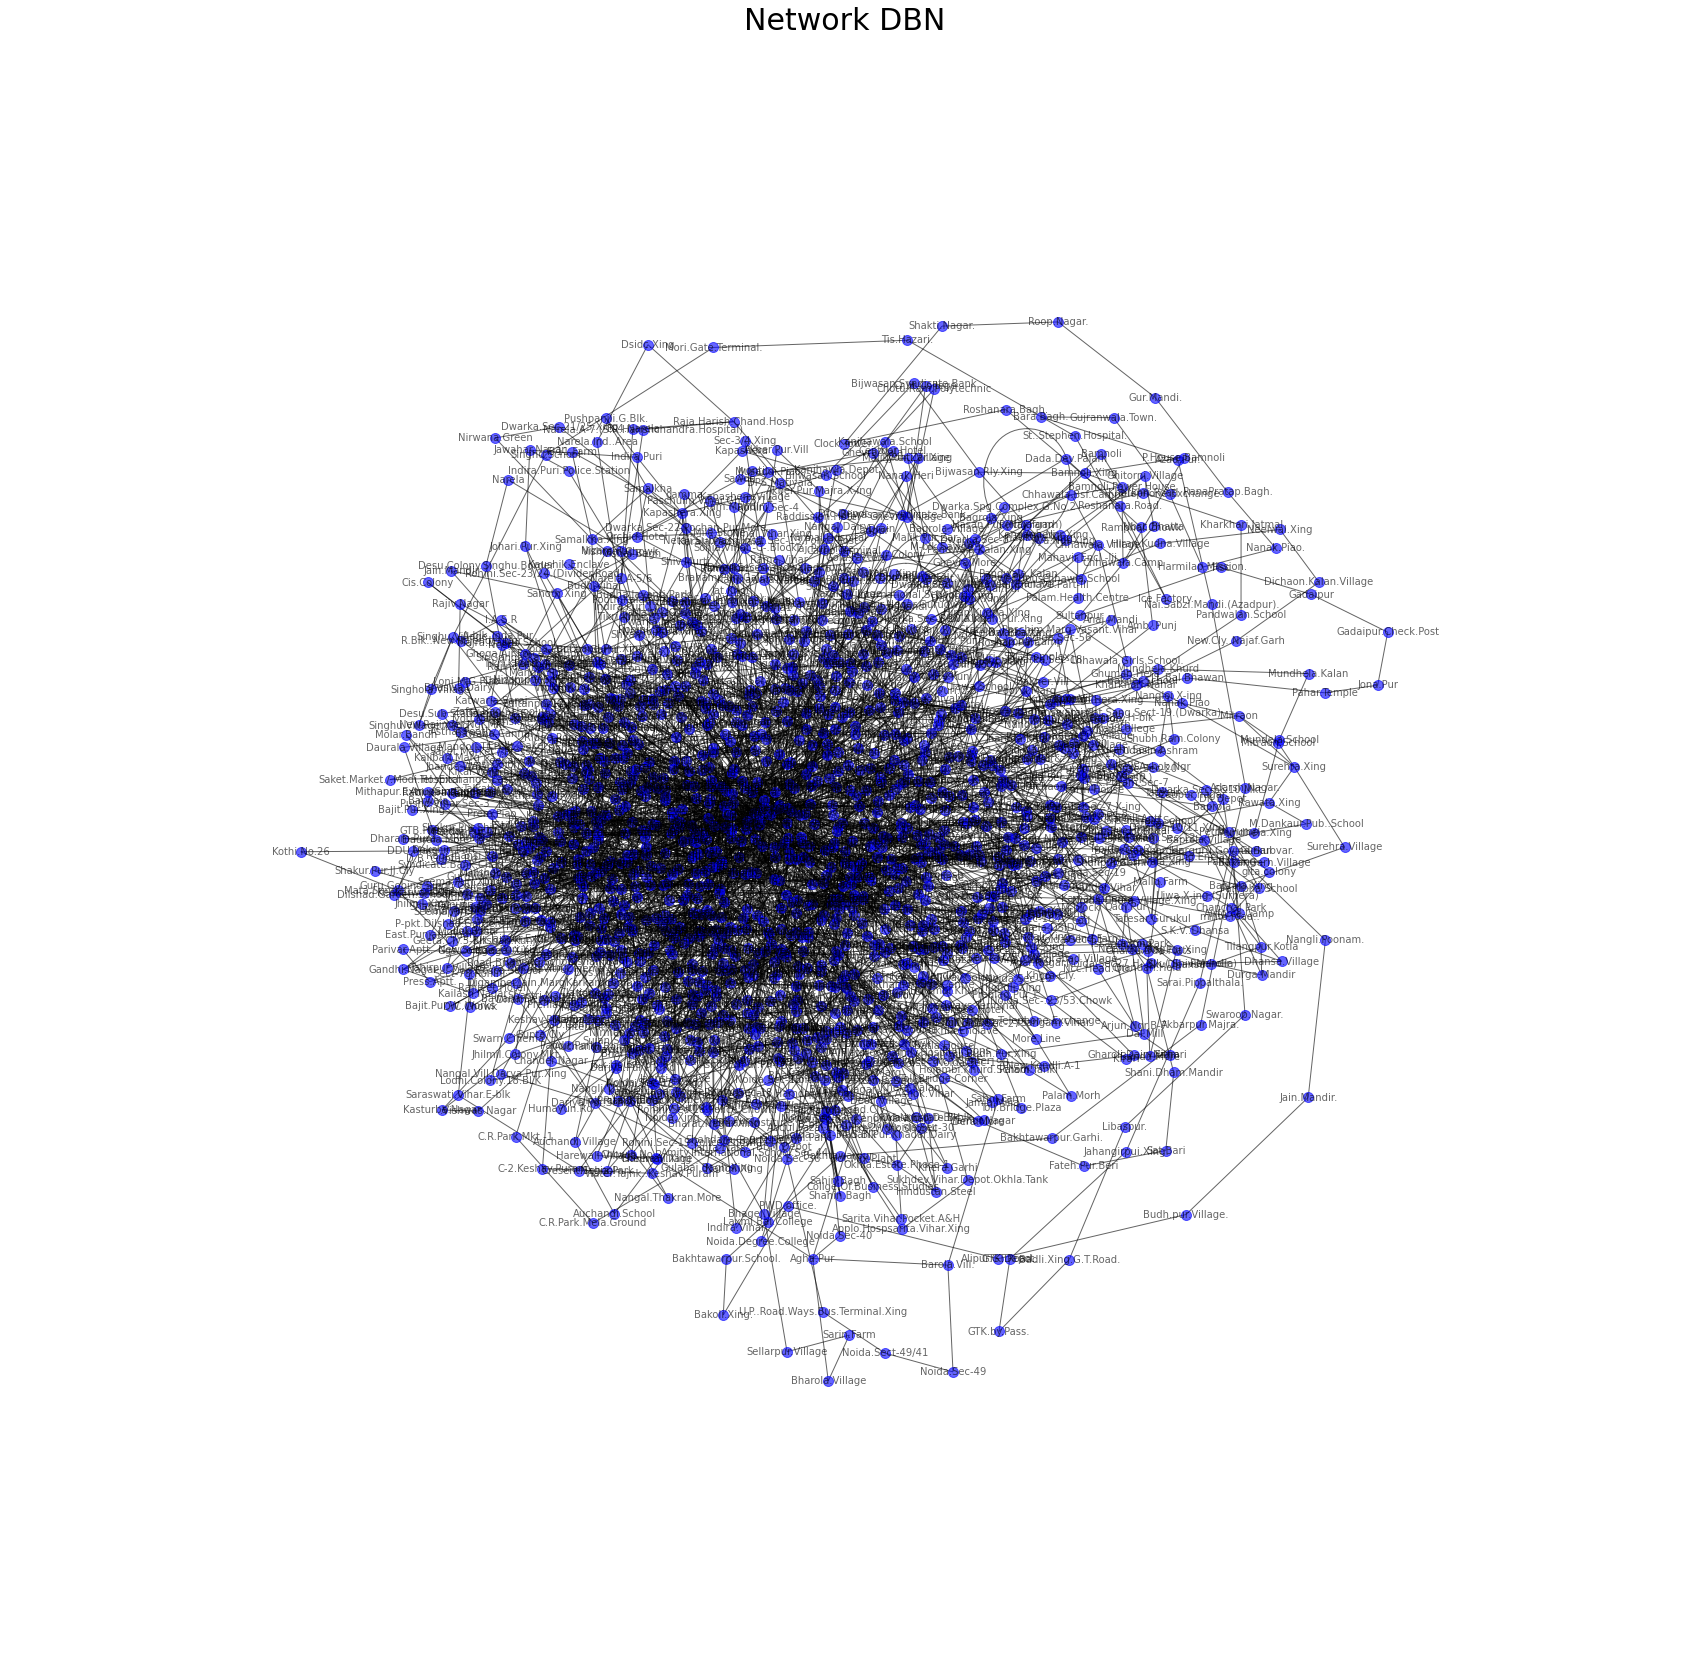

In [5]:
pos = nx.spring_layout(G_pesato, k=0.1)
plt.rcParams["figure.figsize"] = (30,30)
nx.draw_networkx(G_pesato, pos=pos, node_size=100, edge_color="black", alpha=0.6, with_labels=True,
                node_color="blue",font_size=10,font_color="black")
plt.title("Network DBN", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

# Large scale

In [6]:
#La rete è connesssa?
print('\nNetwork is connected?\n',nx.is_connected(G_pesato))                          
comps = sorted(nx.connected_components(G_pesato),
               key=len, reverse=True)



Network is connected?
 True


In [7]:
#average path length
apl=[]
apl.append((round(nx.average_shortest_path_length(G_non_pesato),3)))
apl.append((round(nx.average_shortest_path_length(G_pesato, weight="weight"),3)))
df=pd.DataFrame([apl],columns=["Network non pesata","Network pesata"])
#diametro
diametro=[]
diametro.append(nx.diameter(G_non_pesato))
diametro.append(nx.diameter(G_pesato))
df_length = len(df)
df.loc[df_length] = diametro
#density
density=[]
density.append(round(nx.density(G_non_pesato),4))
density.append(round(nx.density(G_pesato),4))
df_length = len(df)
df.loc[df_length] = density
# average local clustering
alc=[]
alc.append(round(nx.average_clustering(G_non_pesato),4))
alc.append(round(nx.average_clustering(G_pesato,weight='weight'),4))
df_length = len(df)
df.loc[df_length] = alc
#global clustering
global_clustering=[]
global_clustering.append(round(nx.transitivity(G_non_pesato),3))
global_clustering.append(round(nx.transitivity(G_pesato),3))
df_length = len(df)
df.loc[df_length] = global_clustering
indici=["Average Path Length","Diametro","Density","Average Local Clustering","Global Clustering"]
df.index =indici
df


Network non pesata  Network pesata
Average Path Length                   5.5360          6.8810
Diametro                             29.0000         29.0000
Density                               0.0030          0.0030
Average Local Clustering              0.1833          0.0084
Global Clustering                     0.1220          0.1220

# Small scale

In [8]:
#calcolo del grado per la network pesata e non pesata
nx.set_node_attributes(G_non_pesato, name='unweighted_degree', values=dict(nx.degree(G_non_pesato)))
nx.set_node_attributes(G_pesato, name='unweighted_degree', values=dict(nx.degree(G_pesato)))
nx.set_node_attributes(G_pesato, name='weighted_degree', values=dict(nx.degree(G_pesato, weight='weight')))

#calcolo degree centrality
nx.set_node_attributes(G_non_pesato, name='degree_centrality', values=nx.degree_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='degree_centrality', values=nx.degree_centrality(G_pesato))

#calcolo betweeness centrality
nx.set_node_attributes(G_non_pesato, name='betweenness', values=nx.betweenness_centrality(G_non_pesato, normalized=True))
nx.set_node_attributes(G_pesato, name='betweenness', values=nx.betweenness_centrality(G_pesato, normalized=True, weight="weight"))

#calcolo closeness
nx.set_node_attributes(G_non_pesato, name='closeness', values=nx.closeness_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='closeness', values=nx.closeness_centrality(G_pesato))

#calcolo eigenvector
nx.set_node_attributes(G_non_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_non_pesato))
nx.set_node_attributes(G_pesato, name='eigenvector', values=nx.eigenvector_centrality(G_pesato, weight="weight",max_iter=100000))

#calcolo page rank
nx.set_node_attributes(G_non_pesato, name='page_rank', values=nx.pagerank(G_non_pesato))
nx.set_node_attributes(G_pesato, name='page_rank', values=nx.pagerank(G_pesato, weight="weight"))

In [9]:
#creazione del data frame con le varie misure small scale per la rete non pesata
unweightedDF = pd.DataFrame(dict(G_non_pesato.nodes(data=True))).T
unweightedDF

unweighted_degree  degree_centrality  \
Kendriya.Terminal                             52.0           0.033484   
Dr.RML.Hospital                               12.0           0.007727   
NDPO                                          12.0           0.007727   
Regal.Cinema                                  15.0           0.009659   
Upper.Ridge.Road                               6.0           0.003863   
...                                            ...                ...   
M-blk.Sawda                                    2.0           0.001288   
Sawda.Jj.Colony                                2.0           0.001288   
Rohini.Sec-5                                   2.0           0.001288   
Rohini.Sec-23/24.(Divider.Road)                2.0           0.001288   
Nithari                                        2.0           0.001288   

                                 betweenness  closeness  eigenvector  \
Kendriya.Terminal                   0.115843   0.280578     0.312581   
Dr.RML.Hospital                     0.002902   0.230313     0.096351   
NDPO                                0.003692   0.237353     0.144294   
Regal.Cinema                        0.005757   0.247925     0.193676   
Upper.Ridge.Road                    0.003074   0.227146     0.050831   
...                                      ...        ...          ...   
M-blk.Sawda                         0.000321   0.156143     0.000203   
Sawda.Jj.Colony                     0.001394   0.181786     0.002112   
Rohini.Sec-5                        0.000315   0.170772     0.000566   
Rohini.Sec-23/24.(Divider.Road)     0.000110   0.161384     0.000238   
Nithari                             0.000052   0.163096     0.000304   

                                 page_rank  
Kendriya.Terminal                 0.005752  
Dr.RML.Hospital                   0.001205  
NDPO                              0.001208  
Regal.Cinema                      0.001406  
Upper.Ridge.Road                  0.000652  
...                                    ...  
M-blk.Sawda                       0.000422  
Sawda.Jj.Colony                   0.000376  
Rohini.Sec-5                      0.000370  
Rohini.Sec-23/24.(Divider.Road)   0.000364  
Nithari                           0.000412  

[1554 rows x 6 columns]

In [10]:
#creazione del data frame con le varie misure small scale per la rete pesata
weightedDF = pd.DataFrame(dict(G_pesato.nodes(data=True))).T
weightedDF

unweighted_degree  weighted_degree  \
Kendriya.Terminal                             52.0             82.0   
Dr.RML.Hospital                               12.0             25.0   
NDPO                                          12.0             46.0   
Regal.Cinema                                  15.0             27.0   
Upper.Ridge.Road                               6.0              6.0   
...                                            ...              ...   
M-blk.Sawda                                    2.0              2.0   
Sawda.Jj.Colony                                2.0              2.0   
Rohini.Sec-5                                   2.0              4.0   
Rohini.Sec-23/24.(Divider.Road)                2.0              2.0   
Nithari                                        2.0              2.0   

                                 degree_centrality   betweenness  closeness  \
Kendriya.Terminal                         0.033484  1.239231e-01   0.280578   
Dr.RML.Hospital                           0.007727  1.740978e-03   0.230313   
NDPO                                      0.007727  3.970540e-03   0.237353   
Regal.Cinema                              0.009659  2.752532e-03   0.247925   
Upper.Ridge.Road                          0.003863  8.127232e-03   0.227146   
...                                            ...           ...        ...   
M-blk.Sawda                               0.001288  1.007357e-03   0.156143   
Sawda.Jj.Colony                           0.001288  2.261367e-03   0.181786   
Rohini.Sec-5                              0.001288  1.939786e-05   0.170772   
Rohini.Sec-23/24.(Divider.Road)           0.001288  1.306877e-04   0.161384   
Nithari                                   0.001288  8.297874e-07   0.163096   

                                  eigenvector  page_rank  
Kendriya.Terminal                3.288024e-04   0.004524  
Dr.RML.Hospital                  5.446794e-05   0.001127  
NDPO                             1.033112e-04   0.002001  
Regal.Cinema                     7.367770e-05   0.001232  
Upper.Ridge.Road                 9.960242e-05   0.000384  
...                                       ...        ...  
M-blk.Sawda                      8.204197e-05   0.000304  
Sawda.Jj.Colony                  5.837230e-03   0.000253  
Rohini.Sec-5                     3.255925e-07   0.000443  
Rohini.Sec-23/24.(Divider.Road)  2.225466e-07   0.000265  
Nithari                          1.296876e-06   0.000286  

[1554 rows x 7 columns]

# Degree

In [11]:
topNodes = 15
unweightedDF["Label"]=unweightedDF.index
weightedDF["Label"]=weightedDF.index

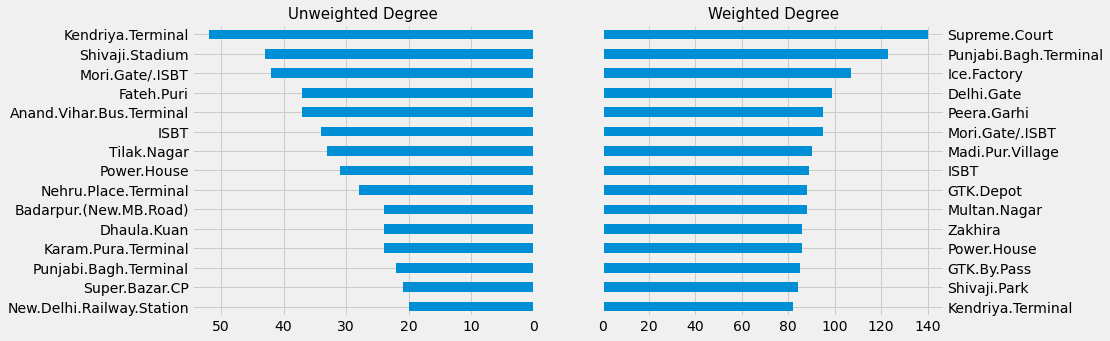

In [13]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='unweighted_degree', ascending=False)[:topNodes].plot(x='Label', y='unweighted_degree', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted Degree", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='weighted_degree', ascending=False)[:topNodes].plot(x='Label', y='weighted_degree', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted Degree", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

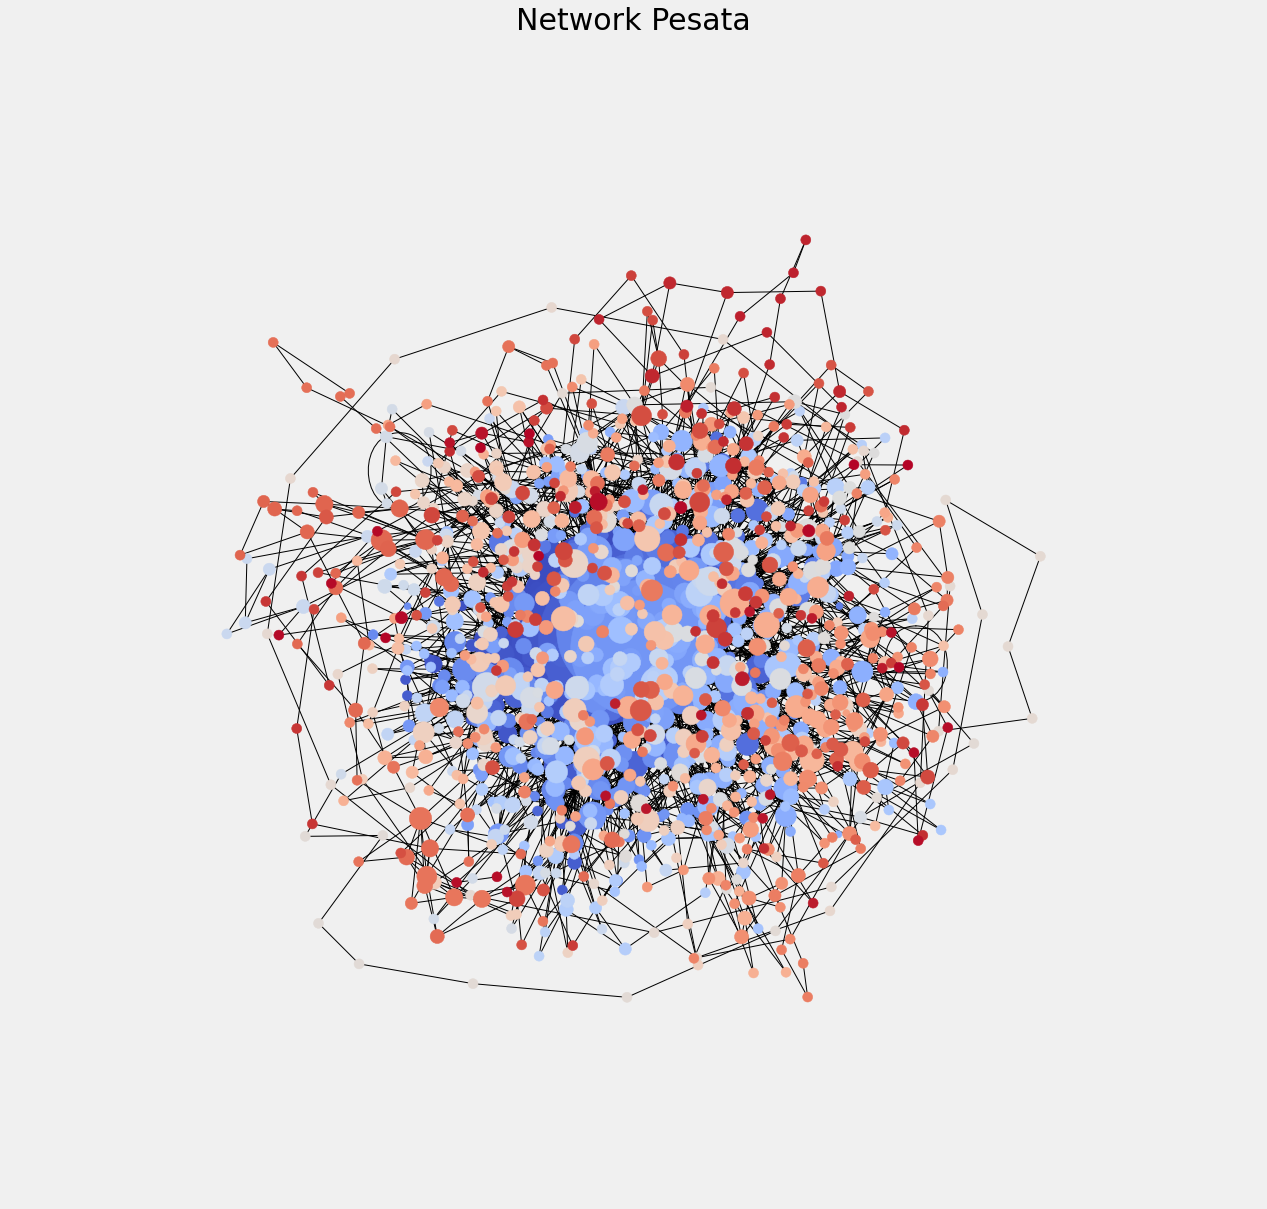

In [14]:
pos = nx.spring_layout(G_pesato, k=0.1)
color_lookup = {k:v for v, k in enumerate(sorted(set(G_pesato.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
node_colors = [mapper.to_rgba(i) for i in color_lookup.values()]
d = dict(list(nx.degree(G_pesato)))
node_sizes = [v*50 if v <= 30 else v*600 for v in d.values()]
plt.rcParams["figure.figsize"] = (20,20)
nx.draw_networkx(G_pesato, pos=pos, node_size=node_sizes, node_color=node_colors, edge_color="black", with_labels=False, font_size=12)
plt.title("Network Pesata", fontsize=30)
ax = plt.gca()
ax.margins(0.20)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.axis("off")

plt.show()

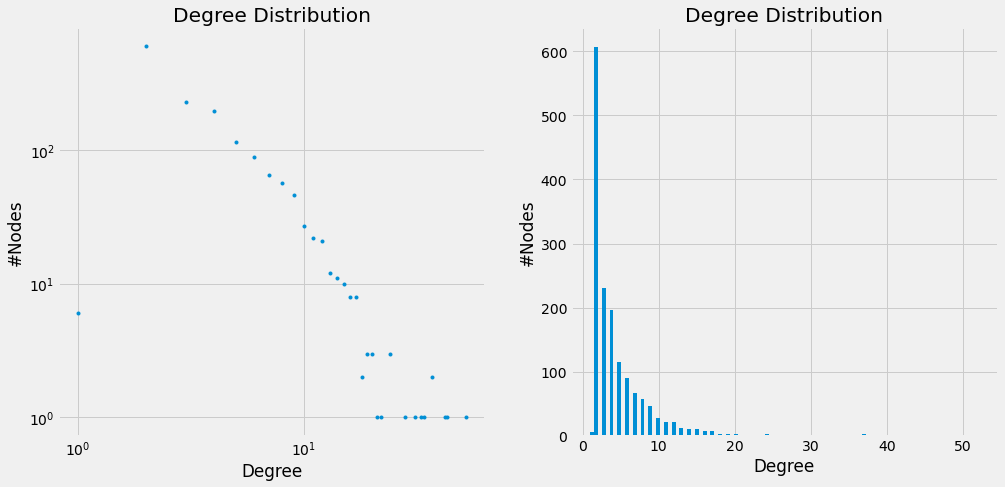

In [15]:
hist = nx.degree_histogram(G_pesato)

plt.rcParams["figure.figsize"] = (15,7)

plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist)), hist,'.')

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

degree_sequence = [G_pesato.degree(n) for n in G_pesato.nodes]

plt.subplot(1, 2, 2)
counts, bins, patches = plt.hist(degree_sequence,bins=100)

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.show()

In [16]:
#creazione di un dataframe per una visualizzazione più rapida dei vari gradi e le relative frequenze
degree_counts = Counter(degree_sequence)
sorted_degree = sorted(degree_counts.items(), 
                       key=lambda item: item[1],reverse=True)
list_gradi=[]
conteggi=[]
for i in range(len(sorted_degree)):
    list_gradi.append(sorted_degree[i][0])
    conteggi.append(sorted_degree[i][1])
df_conteggi=pd.DataFrame(list_gradi,columns=["Grado"])
df_conteggi['Frequenze']=conteggi
df_conteggi

Grado  Frequenze
0       2        607
1       3        230
2       4        196
3       5        115
4       6         90
5       7         66
6       8         57
7       9         46
8      10         27
9      11         22
10     12         21
11     13         12
12     14         11
13     15         10
14     17          8
15     16          8
16      1          6
17     20          3
18     24          3
19     19          3
20     18          2
21     37          2
22     52          1
23     43          1
24     21          1
25     22          1
26     33          1
27     42          1
28     28          1
29     34          1
30     31          1

# Degree Centrality

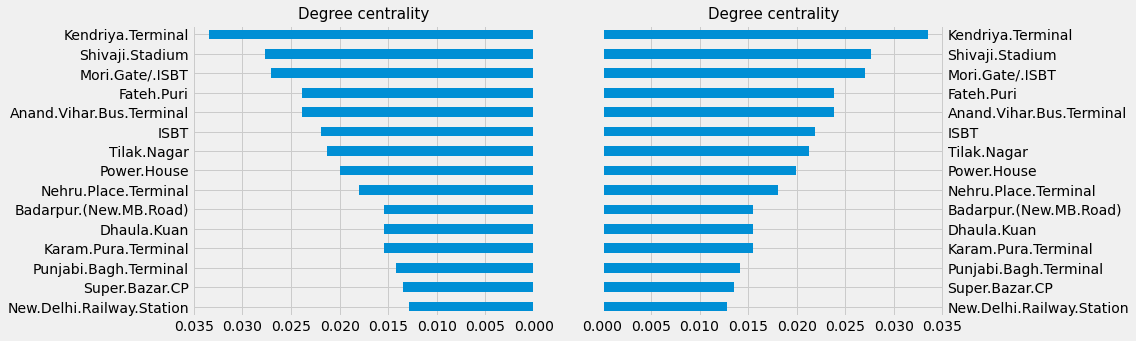

In [17]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')


unweightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Degree centrality", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='degree_centrality', ascending=False)[:topNodes].plot(x='Label', y='degree_centrality', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Degree centrality", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [18]:
if not os.path.isdir('img_dbn'):
    os.mkdir('img_dbn')
title = 'Degree centrality'
adjusted_node_size = dict([(node, 5+degree*175) for node, degree in nx.degree_centrality(G_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("degree_centrality","@degree_centrality")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.degree_centrality(G_pesato).values()), high=max(nx.degree_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Degree centrality.html'

# Betweenness

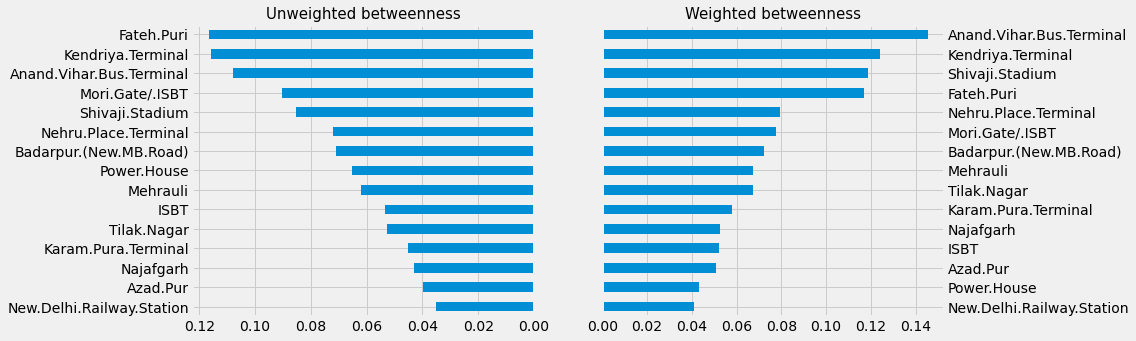

In [19]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted betweenness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='betweenness', ascending=False)[:topNodes].plot(x='Label', y='betweenness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted betweenness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

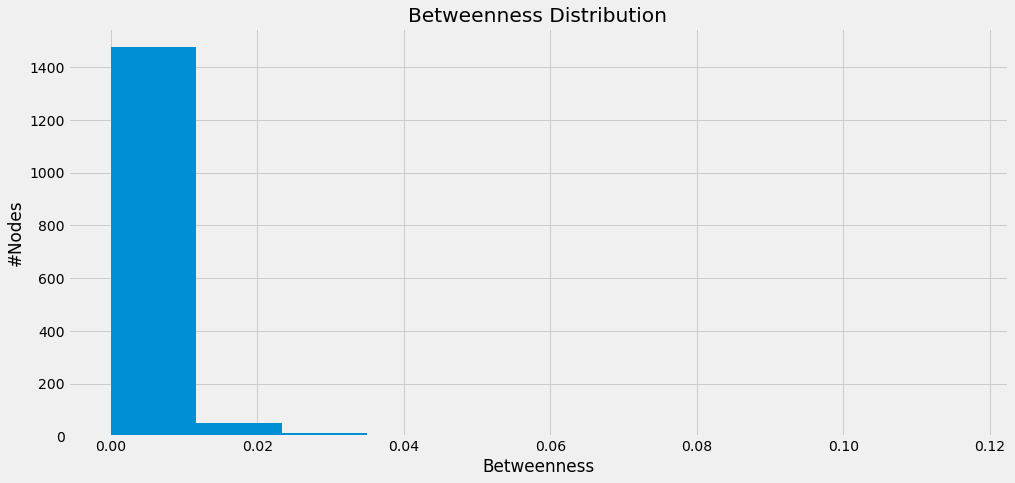

In [20]:
#grafico della distribuzione di frequenze per la betweenness
B = nx.betweenness_centrality(G_pesato,normalized=True)
betweenness_sequence = list(B.values())

counts, bins, patches = plt.hist(betweenness_sequence,bins=10)
plt.title("Betweenness Distribution")
plt.xlabel("Betweenness")
plt.ylabel("#Nodes")
plt.show()

In [21]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Weighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_pesato, normalized=True, weight="weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_pesato, normalized=True, weight="weight").values()), high=max(nx.betweenness_centrality(G_pesato, weight="weight",normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Weighted betweenness.html'

In [22]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Unweighted betweenness'
adjusted_node_size = dict([(node, 5+betweenness*175) for node, betweenness in nx.betweenness_centrality(G_non_pesato, normalized=True).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("betweenneess","@betweenness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.betweenness_centrality(G_non_pesato, normalized=True).values()), high=max(nx.betweenness_centrality(G_non_pesato, normalized=True).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Unweighted betweenness.html'

# Closeness

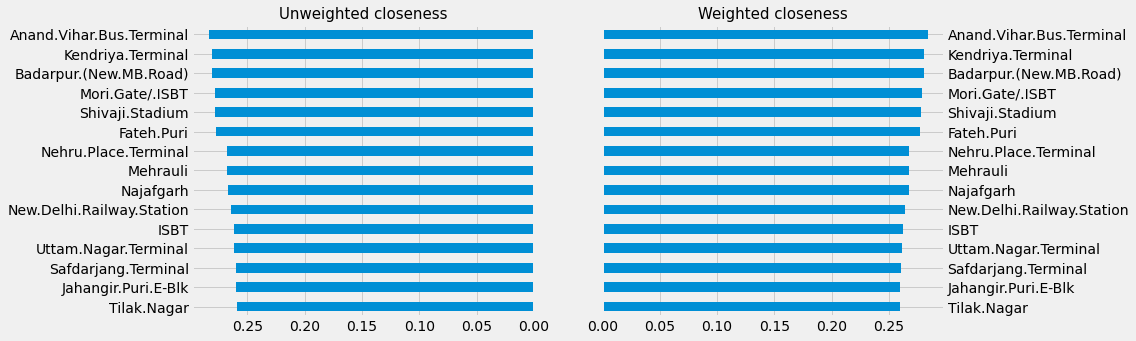

In [23]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))
plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted closeness", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='closeness', ascending=False)[:topNodes].plot(x='Label', y='closeness', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted closeness", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [24]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Closeness'
adjusted_node_size = dict([(node, 5+closeness*15) for node, closeness in nx.closeness_centrality(G_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("closeness","@closeness")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.closeness_centrality(G_pesato).values()), high=max(nx.closeness_centrality(G_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Closeness.html'

# Eigenvector

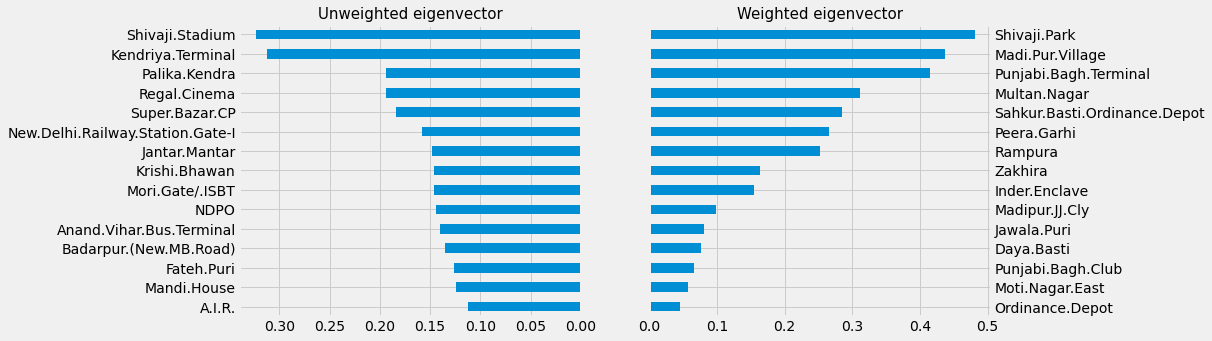

In [25]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted eigenvector", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='eigenvector', ascending=False)[:topNodes].plot(x='Label', y='eigenvector', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted eigenvector", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [26]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Weighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_pesato,weight="weight",max_iter=1000).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_pesato,weight="weight",max_iter=1000).values()), high=max(nx.eigenvector_centrality(G_pesato,weight="weight",max_iter=1000).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Weighted Eigenvector.html'

In [27]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Unweighted Eigenvector'
adjusted_node_size = dict([(node, 5+eigenvector*175) for node, eigenvector in nx.eigenvector_centrality(G_non_pesato).items()])
nx.set_node_attributes(G_non_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("eigenvector","@eigenvector")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_non_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.eigenvector_centrality(G_non_pesato).values()), high=max(nx.eigenvector_centrality(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")


save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Unweighted Eigenvector.html'

# Page Rank

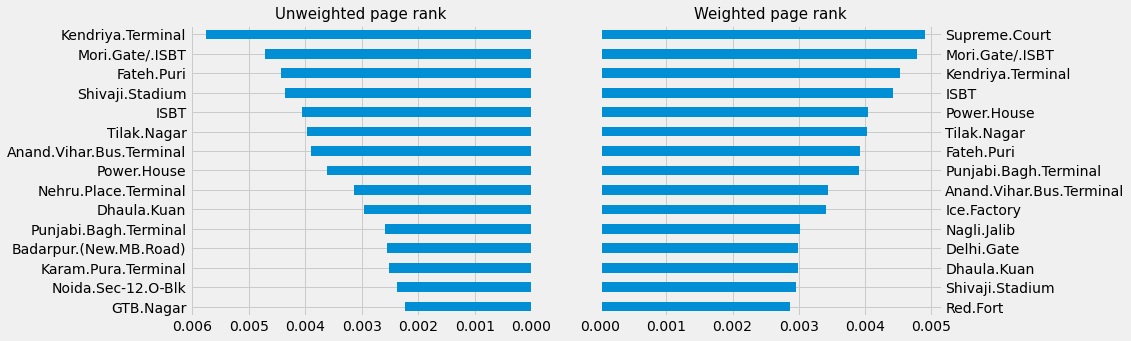

In [28]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12, 5))

plt.style.use('fivethirtyeight')

unweightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax, legend=False).invert_yaxis()
ax.set_title("Unweighted page rank", fontsize=15)
ax.invert_xaxis()
ax.set_ylabel("")


weightedDF.sort_values(by='page_rank', ascending=False)[:topNodes].plot(x='Label', y='page_rank', kind='barh', ax=ax2, legend=False).invert_yaxis()
ax2.set_title("Weighted page rank", fontsize=15)
ax2.yaxis.tick_right()
ax2.set_ylabel("")


plt.show()

In [29]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Weighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*950) for node, page_rank in nx.pagerank(G_pesato, weight="weight").items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_pesato, weight="weight").values()), high=max(nx.pagerank(G_pesato, weight="weight").values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Weighted Pagerank.html'

In [30]:
if not os.path.isdir('img_dbn'):             
    os.mkdir('img_dbn')
title = 'Unweighted Pagerank'
adjusted_node_size = dict([(node, 5+page_rank*950) for node, page_rank in nx.pagerank(G_non_pesato).items()])
nx.set_node_attributes(G_pesato, name='adjusted_node_size', values=adjusted_node_size)

size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'adjusted_node_size'

color_palette = Viridis8

HOVER_TOOLTIPS = [("Label", "@index"),("page_rank","@page_rank")]

plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title,plot_height=900, 
            plot_width=1500)

network_graph = from_networkx(G_pesato, nx.spring_layout, scale=10, center=(0, 0))

minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))



#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

color_bar = ColorBar(
              color_mapper=LogColorMapper(palette="Viridis256", low=min(nx.pagerank(G_non_pesato).values()), high=max(nx.pagerank(G_non_pesato).values())), 
              label_standoff=12)

plot.add_layout(color_bar,"right")
save(plot, filename=f"img_dbn{os.sep}{title}.html")

'c:\\Users\\fidan\\Social Network Analysis\\Progetto\\img_dbn\\Unweighted Pagerank.html'

# Medium Scale

In [31]:
# Find k-cores
G_pesato.remove_edges_from(nx.selfloop_edges(G_pesato))
G_core_4 = nx.k_core(G_pesato, 4)
G_core_5 = nx.k_core(G_pesato, 5)

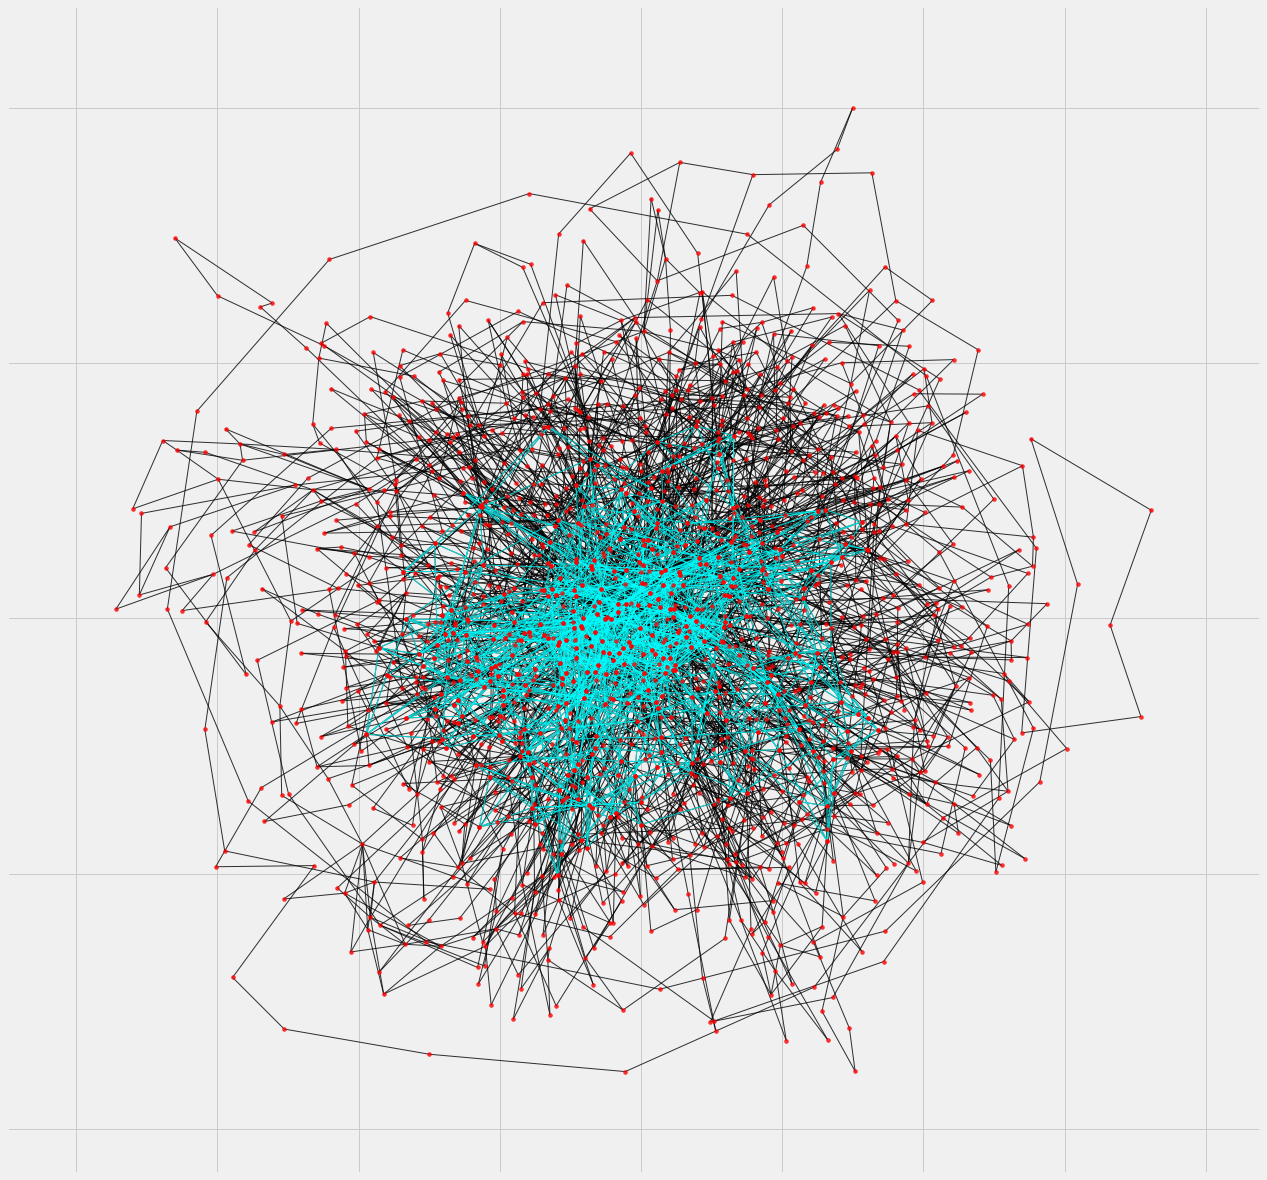

In [33]:
# grafico k kore = 4
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_4, pos=pos, node_size=15, edge_color="cyan", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)
plt.show()

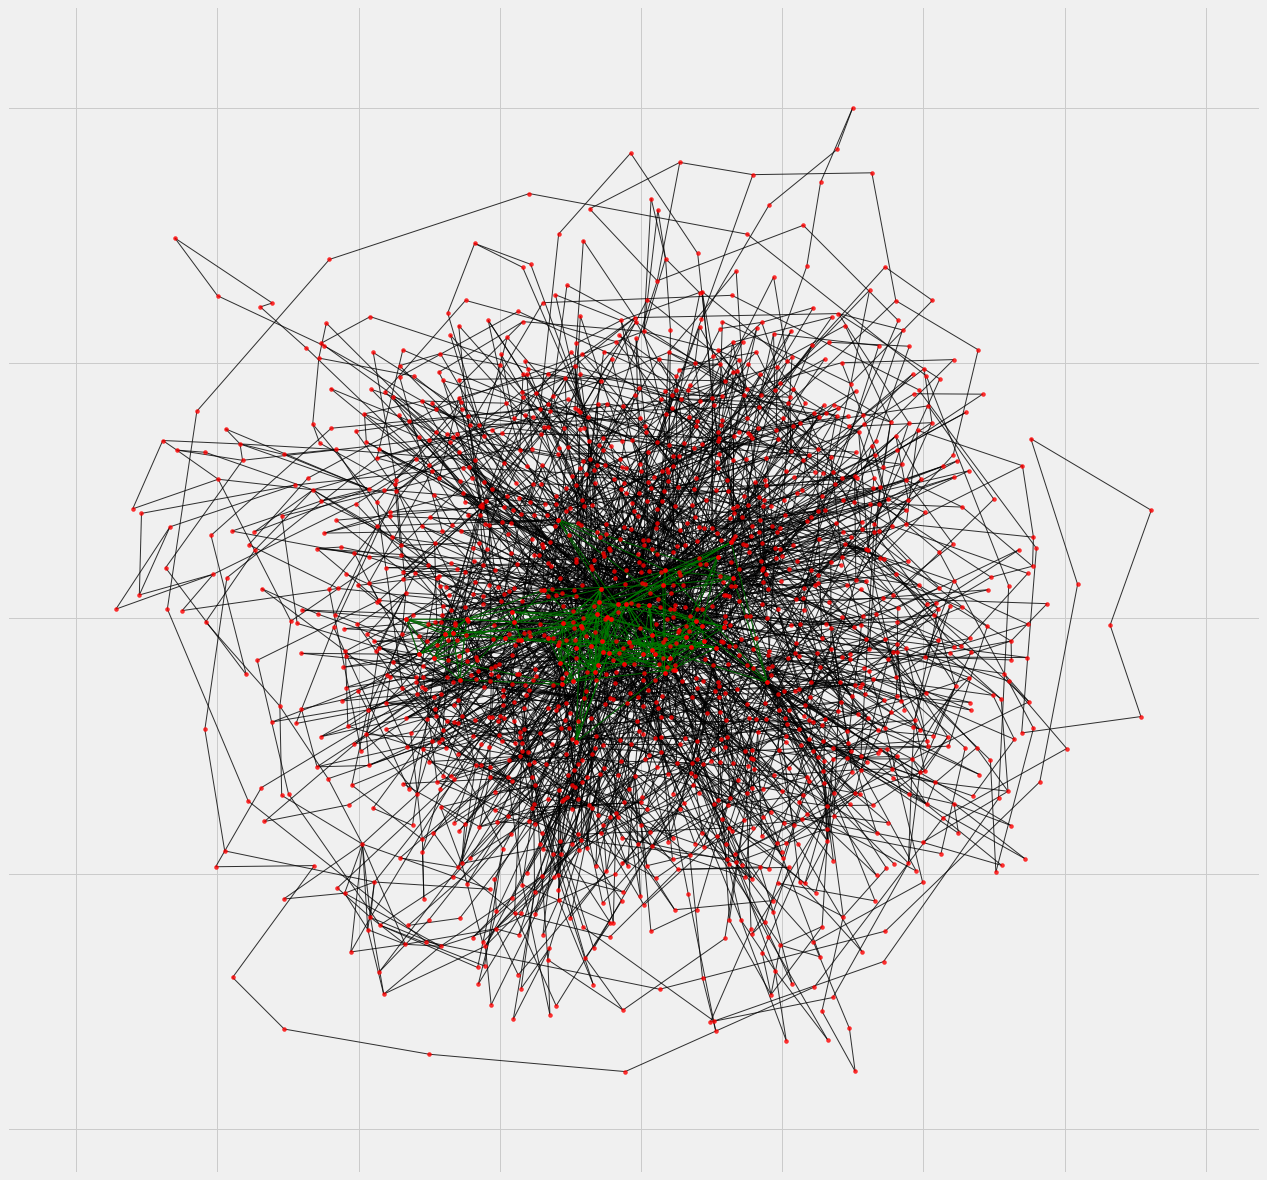

In [34]:
#grafico k kore = 5
nx.draw_networkx(
    G_pesato, pos=pos, node_size=15, edge_color="black", alpha=0.8, with_labels=False,node_color="red")
nx.draw_networkx(
    G_core_5, pos=pos, node_size=15, edge_color="green", alpha=0.8, with_labels=False,node_color="red")
plt.rcParams["figure.figsize"] = (20,20)

In [35]:
def tie_strength(G, v, w):
    # Get neighbors of nodes v and w in G
    v_neighbors = set(G.neighbors(v))
    w_neighbors = set(G.neighbors(w))
    # Return size of the set intersection
    return 1 + len(v_neighbors & w_neighbors)

strength = dict(
    ((v,w), tie_strength(G_pesato, v, w))
    for v, w in G_pesato.edges())

def bridge_span(G):
    # Get list of edges
    edges = G.edges()
    # Copy G
    G = nx.Graph(G)
    # Create result dict
    result = dict()
    for v, w in edges:
        # Temporarily remove edge
        G.remove_edge(v, w)
        # Find distance with edge removed
        try:
            d = nx.shortest_path_length(G, v, w)
            result[(v, w)] = d
        except nx.NetworkXNoPath:
            result[(v, w)] = float('inf')
        # Restore edge
        G.add_edge(v, w)
    return result

span = bridge_span(G_pesato)

In [36]:
# edges ordinati per tie strength
ordered_edges = sorted(strength.items(), key=lambda x: x[1])
print('Edge\t  Strength\tSpan')

for e, edge_strength in ordered_edges:
    print('{}\t{}\t{}'.format(
        str(e), edge_strength, span[e]
    ))


Edge	  Strength	Span
('Kendriya.Terminal', 'Gulabi.Bagh.Dda.Flats')	1	5
('Kendriya.Terminal', 'Kalkaji.DDA.Flats')	1	3
('Kendriya.Terminal', 'Bajit.Pur')	1	3
('Kendriya.Terminal', 'Nehru.Vihar')	1	3
('Kendriya.Terminal', 'Shalimar.Bagh.BH-Blk')	1	3
('Kendriya.Terminal', 'Jhingola.Village')	1	7
('Kendriya.Terminal', 'Holumbi.Kalan')	1	3
('Kendriya.Terminal', 'Manav.Chowk')	1	4
('Kendriya.Terminal', 'New.Kondali.Mkt')	1	4
('Kendriya.Terminal', 'Jagat.Pur.Temple')	1	6
('Kendriya.Terminal', 'Dilshad.Govt..School')	1	4
('Kendriya.Terminal', 'Trilok.Puri.27-Block')	1	3
('Kendriya.Terminal', 'Mayur.Vihar.Phase-II')	1	3
('Kendriya.Terminal', 'Dwarka.Metro.Station.Sec-14')	1	6
('Kendriya.Terminal', 'Khyala.Restt.Cly')	1	4
('Kendriya.Terminal', 'Adhyapak.Nagar')	1	3
('Kendriya.Terminal', 'Admn..Block')	1	3
('Kendriya.Terminal', 'Rohini.Sec-24.Pkt-18')	1	5
('Kendriya.Terminal', 'Neelwal.Village')	1	4
('Kendriya.Terminal', 'Bakar.Wala.JJ.Cly')	1	3
('Kendriya.Terminal', 'Kair.Village')	1	4
('Kendri

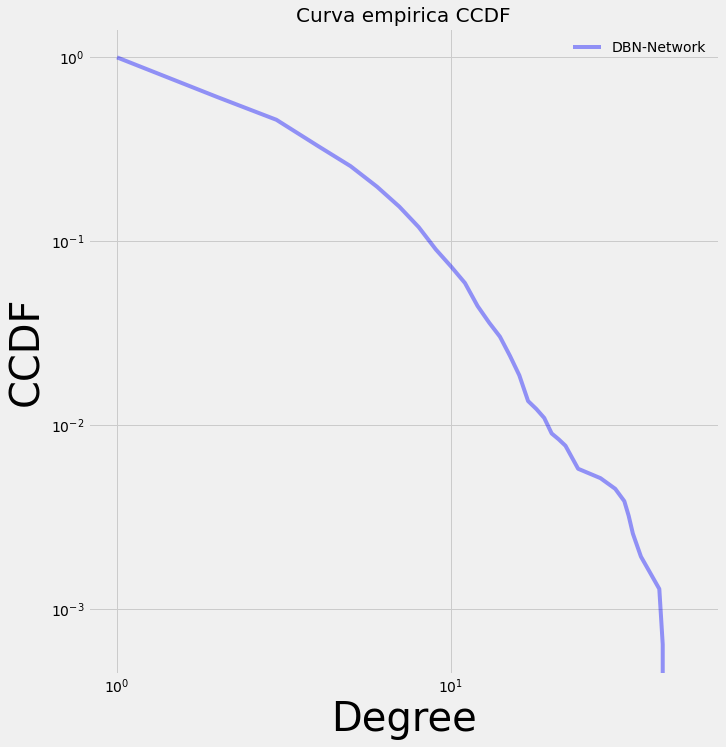

In [37]:
# grafico ccdf
degrees = [G_pesato.degree(u) for u in G_pesato]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, label="DBN-Network")
decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.title("Curva empirica CCDF", fontsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()


# Random Network Erdos-Renyi

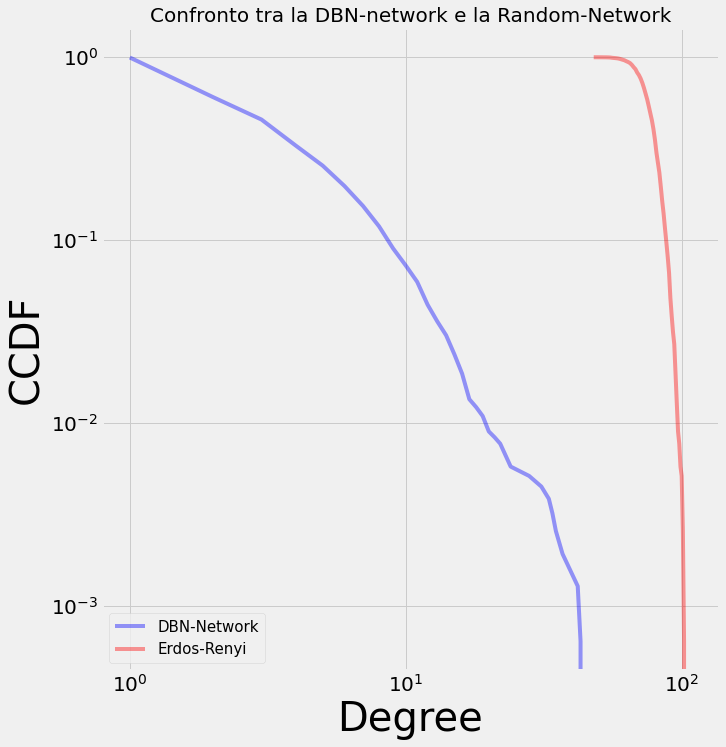

Average degree Random Network: 77.43629343629344
Average degree DBN Network: 4.633204633204633
Il global clustering della network DBN è:  0.122
Il global clustering della random network è:  0.05
L'APL della network DBN è:  5.536
L'APL della random network è:  1.97


In [38]:
erdos_renyi=nx.erdos_renyi_graph(len(G_pesato),0.05,seed=1)
degrees_er = [erdos_renyi.degree(i) for i in erdos_renyi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4, xlabel='Degree', ylabel="CCDF", label="DBN-Network")


cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Renyi")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la DBN-network e la Random-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Random Network:",sum(dict(erdos_renyi.degree()).values())/len(erdos_renyi))
print("Average degree DBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network DBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della random network è: ",(round(nx.transitivity(erdos_renyi),3)))
print("L'APL della network DBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della random network è: ",(round(nx.average_shortest_path_length(erdos_renyi),3)))


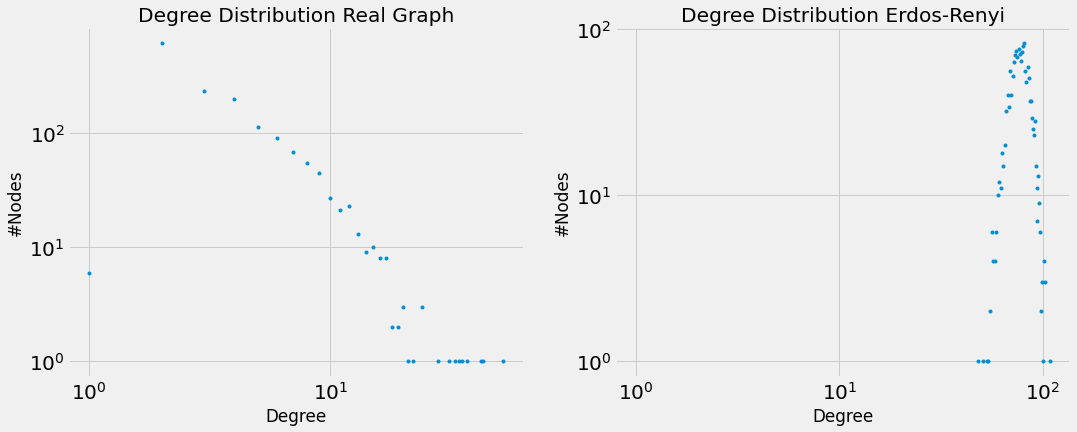

In [39]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(erdos_renyi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Erdos-Renyi")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Small word Watts-Strogatz

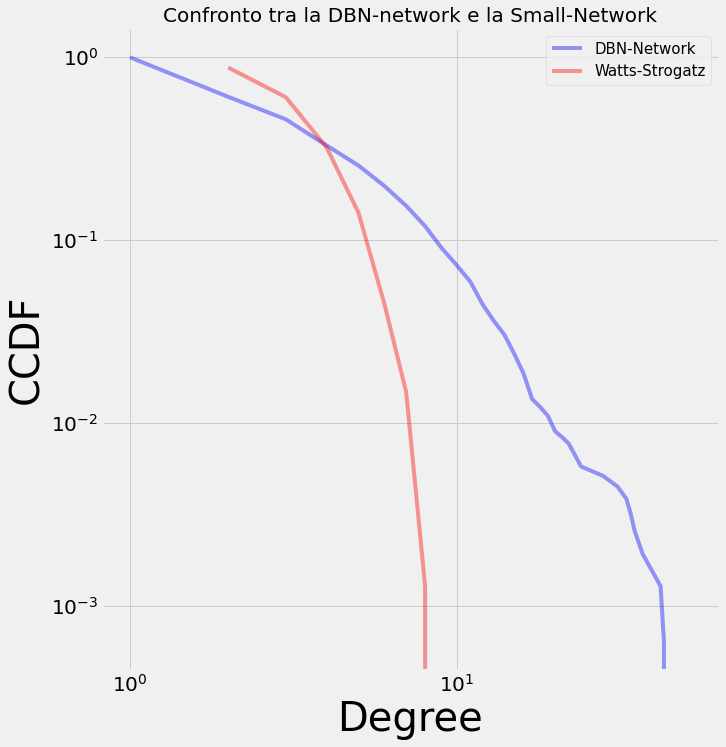

Average degree Small word: 4.0
Average degree DBN Network: 4.633204633204633
Il global clustering della network DBN è:  0.122
Il global clustering della Small word network è:  0.002
L'APL della network DBN è:  5.536
L'APL della small word network è:  5.704


In [40]:
watts_strogatz = nx.watts_strogatz_graph(len(G_pesato.nodes), int(round(2*len(G_pesato.edges())/len(G_pesato))), 1, seed=1)
degrees_ws = [watts_strogatz.degree(i) for i in watts_strogatz]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="DBN-Network")


cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Watts-Strogatz")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')

plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la DBN-network e la Small-Network", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Small word:",sum(dict(watts_strogatz.degree()).values())/len(watts_strogatz))
print("Average degree DBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network DBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering della Small word network è: ",(round(nx.transitivity(watts_strogatz),3)))
print("L'APL della network DBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL della small word network è: ",(round(nx.average_shortest_path_length(watts_strogatz),3)))

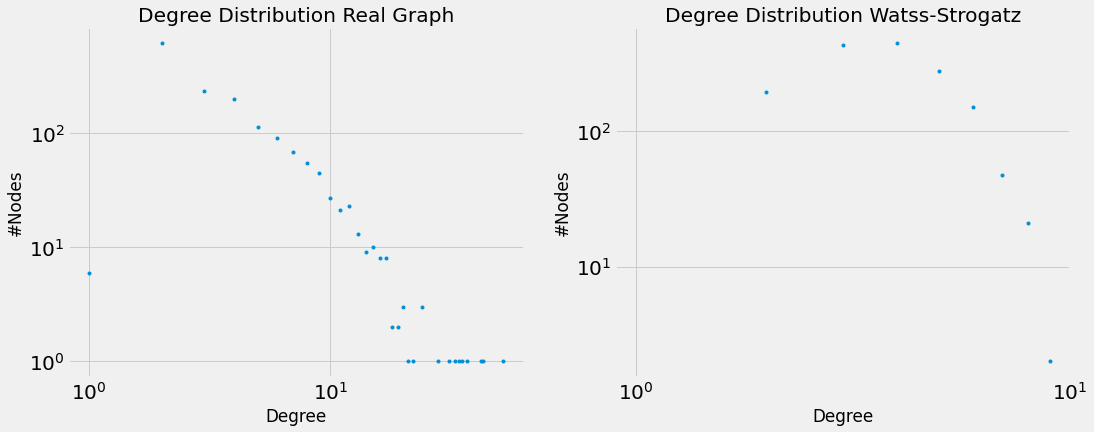

In [41]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(watts_strogatz)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Watss-Strogatz")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Barabasi Albert

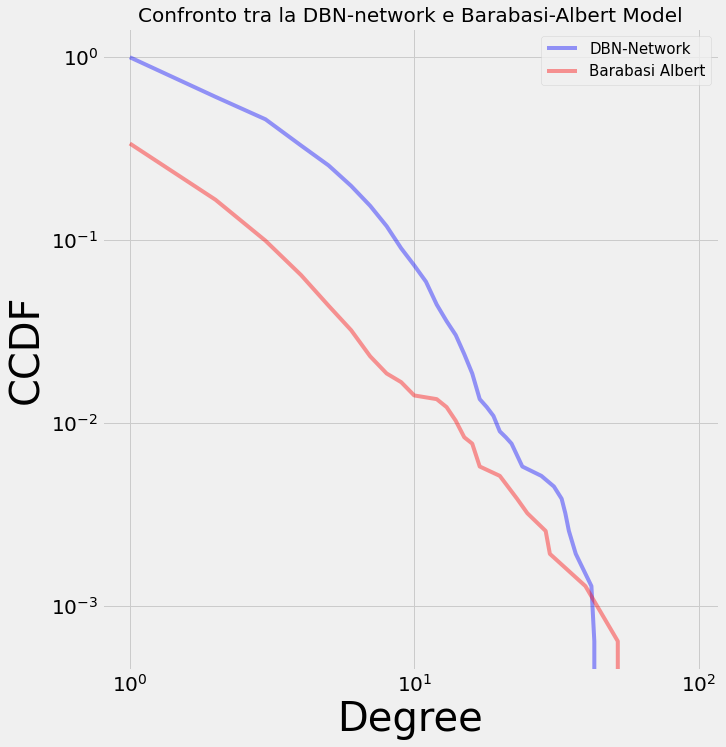

Average degree Barabasi-Albert: 1.9987129987129988
Average degree DBN Network: 4.633204633204633
Il global clustering della network DBN è:  0.122
Il global clustering del modello di Barabasi-Albert è:  0
L'APL della network DBN è:  5.536
L'APL del modello di Barabasi- Albert è:  7.45


In [42]:
barabasi = nx.barabasi_albert_graph(len(G_pesato.nodes), 1,seed=1)
degrees_barabasi = [barabasi.degree(i) for i in barabasi]
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="DBN-Network")


cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF",label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
                 
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.title("Confronto tra la DBN-network e Barabasi-Albert Model", fontsize=20)
plt.legend(fontsize=15)
plt.show()

print("Average degree Barabasi-Albert:",sum(dict(barabasi.degree()).values())/len(barabasi))
print("Average degree DBN Network:",sum(dict(G_pesato.degree()).values())/len(G_pesato))
print("Il global clustering della network DBN è: ",(round(nx.transitivity(G_pesato),3)))
print("Il global clustering del modello di Barabasi-Albert è: ",(round(nx.transitivity(barabasi),3)))
print("L'APL della network DBN è: ",(round(nx.average_shortest_path_length(G_pesato, weight="Weight"),3)))
print("L'APL del modello di Barabasi- Albert è: ",(round(nx.average_shortest_path_length(barabasi),3)))

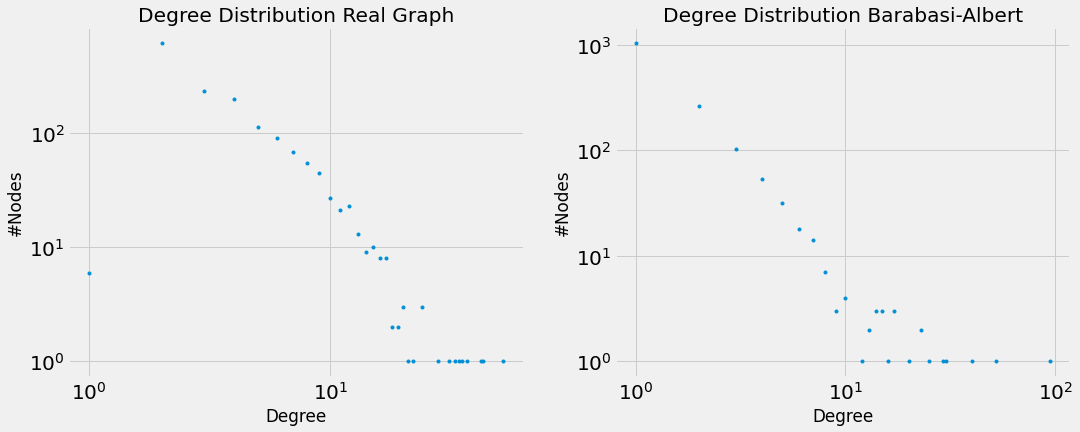

In [43]:
hist_1 = nx.degree_histogram(G_pesato)
hist = nx.degree_histogram(barabasi)

fig = plt.figure(figsize=(16, 6)) 
plt.subplot(1, 2, 1)
plt.plot(range(0, len(hist_1)), hist_1, ".")
plt.title("Degree Distribution Real Graph")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()

plt.subplot(1, 2, 2)
plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution Barabasi-Albert")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

# Confronto tra i vari modelli della CCDF

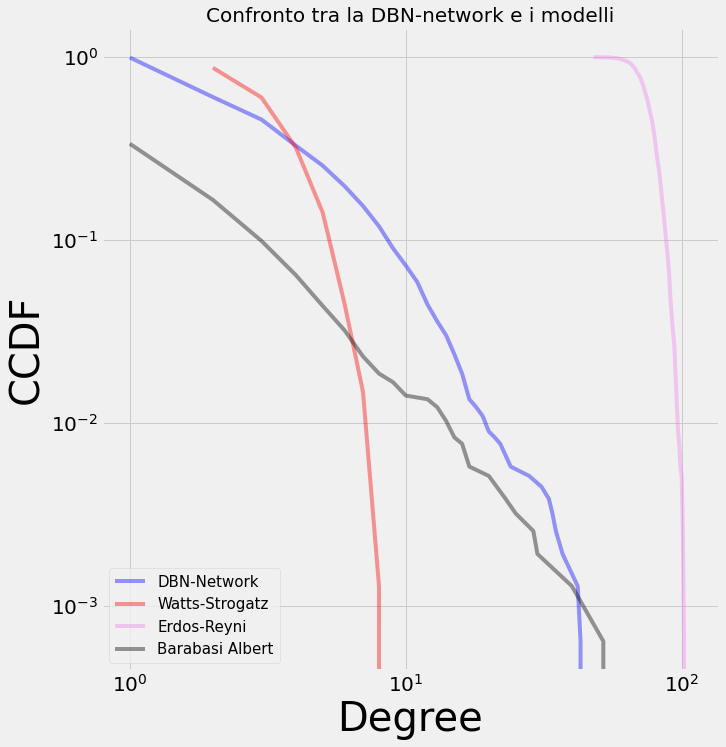

In [44]:
plt.rcParams["figure.figsize"] = (10,10)

cdf = Cdf.from_seq(degrees, name='distribution')
(1 - cdf).plot(color='b', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="DBN-Network")

cdf = Cdf.from_seq(degrees_ws, name='distribution')
(1 - cdf).plot(color='r', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Watts-Strogatz")

cdf = Cdf.from_seq(degrees_er, name='distribution')
(1 - cdf).plot(color='violet', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Erdos-Reyni")

cdf = Cdf.from_seq(degrees_barabasi, name='distribution')
(1 - cdf).plot(color='black', alpha=0.4,xlabel='Degree',ylabel="CCDF", label="Barabasi Albert")

decorate(xlabel='Degree', xscale='log',
                 ylabel='CCDF', yscale='log')
plt.legend(["DBN-Network","Watts-Strogatz","Erdos-Renyi","Barabasi-Albert"])
plt.title("Confronto tra la DBN-network e i modelli", fontsize=20)
plt.xlabel("Degree",fontsize=40)
plt.ylabel("CCDF",fontsize=40)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.legend(fontsize=15)
plt.show()
